In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# !pip install pafy youtube-dl moviepy

In [ ]:
import os
import cv2
# import pafy
import math
import random
import numpy as np
# import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
from moviepy.editor import *
%matplotlib inline
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

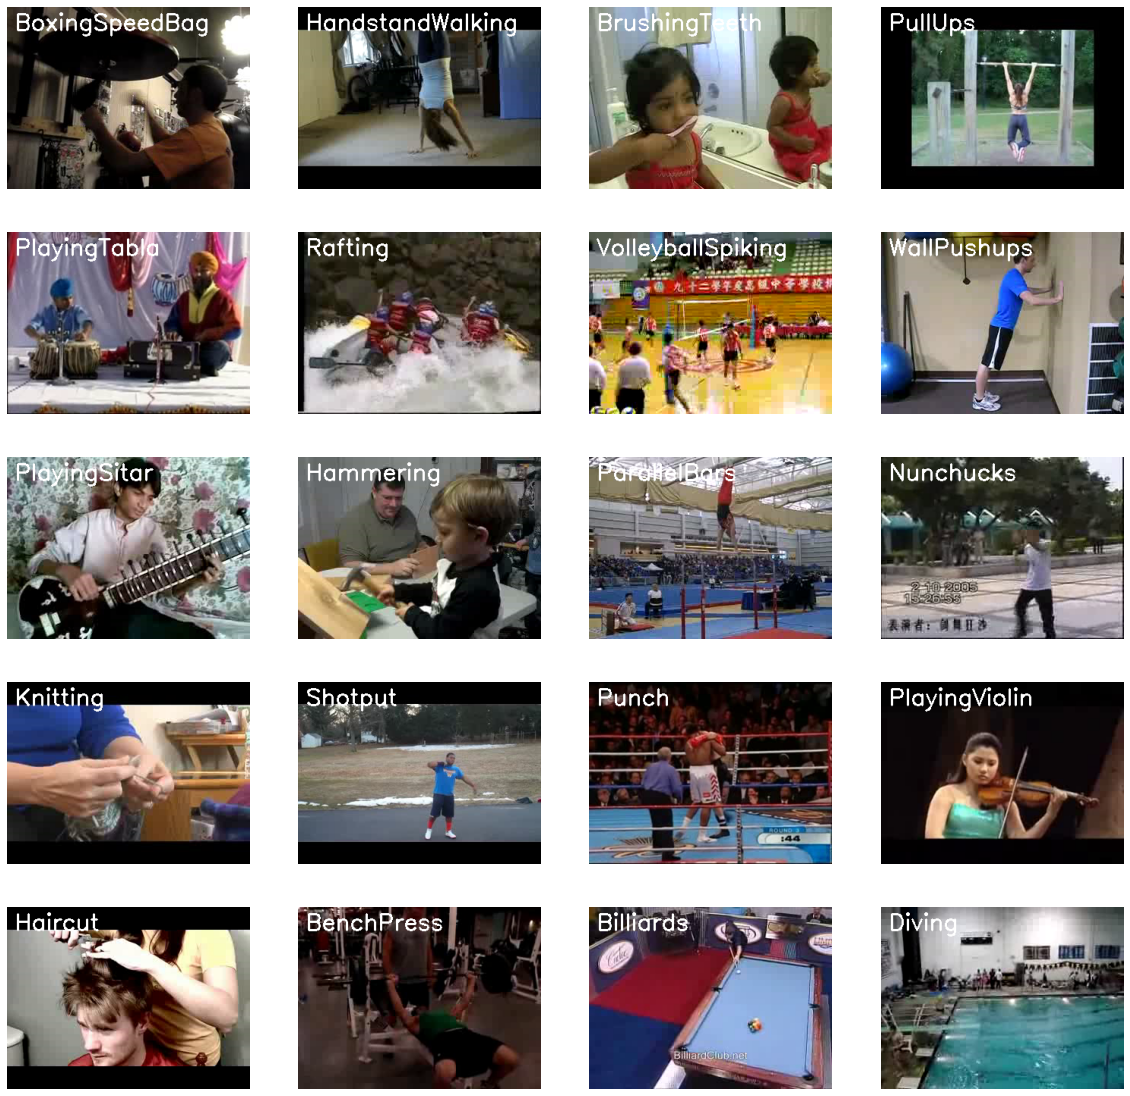

In [ ]:
plt.figure(figsize = (20, 20))
 
datapath="/content/drive/MyDrive/UCF-101"
all_classes_names = os.listdir(datapath)
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'{datapath}/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{datapath}/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "/content/drive/MyDrive/UCF-101"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST =['PlayingCello', 'PlayingGuitar', 'PlayingDhol',
         'PlayingFlute', 'PlayingPiano', 'PlayingSitar',
         'PlayingTabla','PlayingViolin','PlayingDaf','Drumming']

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:

# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: PlayingCello
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: PlayingDhol
Extracting Data of Class: PlayingFlute
Extracting Data of Class: PlayingPiano
Extracting Data of Class: PlayingSitar
Extracting Data of Class: PlayingTabla
Extracting Data of Class: PlayingViolin
Extracting Data of Class: PlayingDaf
Extracting Data of Class: Drumming


In [ ]:

# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
# features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,  test_size = 0.2, shuffle = True, random_state = seed_constant)


In [ ]:
# Split the Data into Train ( 70% ) and Test Set ( 30% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,  test_size = 0.3, shuffle = True, random_state = seed_constant)


In [ ]:
# Split the Data into Train ( 60% ) and Test Set ( 40% ).
# features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,  test_size = 0.4, shuffle = True, random_state = seed_constant)


In [ ]:
# # Training Out model using cnn 2d conv neural network
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import Dense

# from tensorflow.keras.regularizers import l2

# def create_cnn_model():

#     cnn = tf.keras.models.Sequential()

#     # Step 1 - Convolution
#     cnn.add(tf.keras.layers.Conv2D(filters=4,padding="same",kernel_size=3, activation='tanh', strides=2, 
#                                    input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

#     # Step 2 - Pooling
#     # cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#     cnn.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

#     # Adding a second convolutional layer
#     cnn.add(tf.keras.layers.Conv2D(filters=8,padding='same',kernel_size=3, activation='tanh'))
#     # cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#     cnn.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

#         # Adding a second convolutional layer
#     cnn.add(tf.keras.layers.Conv2D(filters=12,padding='same',kernel_size=3, activation='tanh'))
#     # cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#     cnn.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))


#     # Adding a second convolutional layer
#     cnn.add(tf.keras.layers.Conv2D(filters=16,padding='same',kernel_size=3, activation='tanh'))
#     # cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#     cnn.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

#     # Step 3 - Flattening
#     cnn.add(tf.keras.layers.Flatten())

#     # Step 4 - Full Connection
#     cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

#     # Step 5 - Output Layer
 

#     ## for mulitclassification
#     cnn.add(Dense(len(CLASSES_LIST), kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
#                 ='softmax'))
#     cnn.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['accuracy'])
#     cnn.summary()
#     return cnn;



# # ------
# cnn_model = create_cnn_model()

# print("CNN Model Created Successfully!")

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
cnn_model.compile(loss = 'squared_hinge', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
# convlstm_model_training_history = cnn_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])
convlstm_model_training_history = cnn_model.fit(x = features_train, y = labels_train, epochs = 75, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback ])

In [ ]:

# !pip install pyyaml h5py 

In [ ]:
# Saving Cnn model
# cnn_model.save('cnnModel_60_40.h5')

In [ ]:
cnnModel = tf.keras.models.load_model('/content/drive/MyDrive/cnn+svm_models/cnnModel_70_30.h5')



In [ ]:
predi_of_features_test = cnnModel.predict(features_test);
y_pred_labels = np.argmax(predi_of_features_test, axis=1) 
model_evaluation_history = cnnModel.evaluate(features_test, labels_test)
labels_test_classes=np.argmax(labels_test, axis=1) 

14/14 [==============================] - 3s 207ms/step - loss: 0.9327 - accuracy: 0.9234


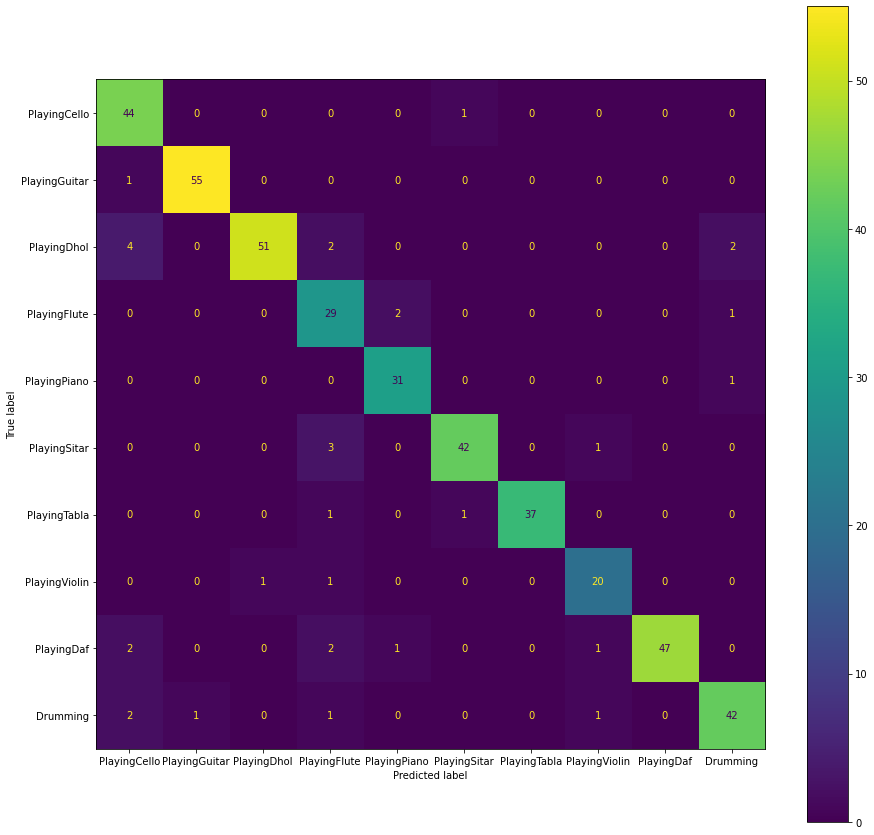

In [ ]:
# confusion_matrix(labels_test_classes, y_pred_labels, CLASSES_LIST)
# y_true = [2, 0, 2, 2, 0, 1]
# y_pred = [0, 0, 2, 2, 0, 2]
cm = confusion_matrix(y_true=y_pred_labels, y_pred=labels_test_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_LIST)
# disp.plot()
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
# plt.show()

In [ ]:


# We will store the results in a dictionary for easy access later
per_class_accuracies = {}

# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(CLASSES_LIST):
    # True negatives are all the samples that are not our current GT class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)

In [ ]:
per_class_accuracies

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = '/content/drive/MyDrive/Videos for testing'
# os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title ='PlayingDhol'

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.avi'


In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = cnnModel.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255 , 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.avi'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|█████████▉| 297/298 [00:01<00:00, 272.79it/s]


In [ ]:
# Precision measures how accurate is your predictions. i.e. the percentage of your predictions are correct.
from sklearn.metrics import precision_score
# precision  ->   tp / (tp + fp)
precision_score(y_pred_labels, labels_test_classes, average=None)
# prec = precision_score(y_pred_labels, labels_test_classes)

array([0.83333333, 0.98181818, 0.98076923, 0.75609756, 0.82051282,
       0.88372093, 0.96551724, 0.65217391, 1.        , 0.83333333])

In [ ]:
# Recall measures how good you find all the positives. For example, we can find 80% of the possible positive cases in our top K predictions.
from sklearn.metrics import recall_score
# recall_score  ->   tp / (tp + fn)
recall_score(y_pred_labels, labels_test_classes, average=None)

array([0.95744681, 0.91525424, 0.83606557, 0.83783784, 0.91428571,
       0.92682927, 0.93333333, 0.75      , 0.88235294, 0.83333333])

In [ ]:
from sklearn.metrics import f1_score

# calculate f1_score
score = f1_score(y_pred_labels, labels_test_classes, average=None)
score

array([0.89108911, 0.94736842, 0.90265487, 0.79487179, 0.86486486,
       0.9047619 , 0.94915254, 0.69767442, 0.9375    , 0.83333333])